In [1]:
import numpy as np
import matplotlib.pyplot as plt
import databehandling.matlib as matlib
import matplotlib

In [2]:
# Parameters

m = {'name': 'UDGRP', 'units': 'MPa-mm-Mg', 'rho': 2e-09, 
     'E1': 38000, 'E2': 8500, 'v12': 0.28, 'G12': 3400, 
     'XT': 1150, 'YT': 40, "ZT":0, "ZC":0, 'XC': 700, 'YC': 120, 'S12': 60, 'S23': 40, "S13":0, 'f12': -0.5}

d1 = 0.9 # Degradation factor transverse mod and shear mod
d2 = 0.1 # Degradation factor compression
m2 = {'name': 'UDGRP', 'units': 'MPa-mm-Mg', 'rho': 2e-09, 
     'E1': 38000, 'E2': 8500*(1-d1), 'v12': 0.28, 'G12': 3400*(1-d1), 
     'XT': 1150, 'YT': 40, "ZT":0, "ZC":0, 'XC': 700*(1-d2), 'YC': 120, 'S12': 60, 'S23': 40, "S13":0, 'f12': -0.5}

legendsize = 15
def set_plot_props():
    legendsize = 15
    plt.figure(figsize=(9,9))
    #matplotlib.rc('xtick', labelsize=15) 
    #matplotlib.rc('ytick', labelsize=15)
    SMALL_SIZE = 8
    MEDIUM_SIZE = 10
    BIGGER_SIZE = 12

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=18)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
# Functions

def S2D(m):
    return np.array([[        1/m['E1'], -m['v12']/m['E1'],          0],
                     [-m['v12']/m['E1'],         1/m['E2'],          0],
                     [                0,                 0, 1/m['G12']]], float)

def Q2D(m):
    S=S2D(m)
    return np.linalg.inv(S)


def T2Ds(a):
    c,s = np.cos(np.radians(a)), np.sin(np.radians(a))
    return np.array([[ c*c ,  s*s ,   2*c*s],
                     [ s*s ,  c*c ,  -2*c*s],
                     [-c*s,   c*s , c*c-s*s]], float)

# Strain transform, global to local
def T2De(a):
    c,s = np.cos(np.radians(a)), np.sin(np.radians(a))
    return np.array([[   c*c,   s*s,     c*s ],
                     [   s*s,   c*c,    -c*s ],
                     [-2*c*s, 2*c*s, c*c-s*s ]], float)

def Q2Dtransform(Q,a):
    return np.dot(np.linalg.inv( T2Ds(a) ) , np.dot(Q,T2De(a)) )

def laminateThickness(layup):
    return sum([layer['thi'] for layer in layup])

def fE_max_stress(s, m):
    return max(s[0]/m["XT"], -s[0]/m["XC"])
    


def computeA(layup):
    A=np.zeros((3,3),float)
    hbot = -laminateThickness(layup)/2        # bottom of first layer
    for layer in layup:
        m = layer['mat']
        Q = Q2D(m)
        a = layer['ori']
        Qt = Q2Dtransform(Q,a)
        htop = hbot + layer['thi']   # top of current layer
        A = A + Qt*(htop-hbot)
        hbot=htop                    # for the next layer
    return A

def fE_hashin(s,m):
    s1,s2,s3,s23,s13,s12=s[0],s[1],s[2],s[3],s[4],s[5]
    XT,YT,ZT,XC,YC,ZC,S12,S13,S23 = m['XT'], m['YT'], m['ZT'], m['XC'], m['YC'], m['ZC'], m['S12'], m['S13'], m['S23']
    if s1>0:
        R = ( 1/( (s1/XT)**2 + (1/S12**2)*(s12**2 + s13**2) ) )**0.5
        fE_FF=1/R
    if s1<=0:
        fE_FF=-s1/XC
    if (s2+s3)>=0:
        temp=( (1/YT**2)*(s2+s3)**2+(1/S23**2)*(s23**2-s2*s3)+(1/S12**2)*(s12**2+s13**2) )
        if temp==0:
            fE_IFF = 0
        else:
            R = (1/temp)**0.5
            fE_IFF = 1/R
    if (s2+s3)<0:
        b = (1/YC)*((YC/(2*S23))**2-1)*(s2+s3)
        a = (1/(4*S23**2))*(s2+s3)**2+(1/S23**2)*(s23**2-s2*s3)+(1/S12**2)*(s12**2+s13**2)
        if a==0:
            fE_IFF = 0.0
        else:
            c=-1
            R=(-b+(b**2-4*a*c)**0.5)/(2*a)
            fE_IFF = 1/R
    return fE_FF, fE_IFF

def fE_hashin_2D(s, m):
    sV = s
    YT = m["YT"]
    S12 = m["S12"]
    YC = m["YC"]
    S23 = m["S23"]
    if(sV[1] >= 0):
        temp = ((1/YT**2)*sV[1]**2)+((1/S12**2)*sV[2]**2)
        if temp == 0:
            fe = 0
        else:
            R = (1/temp)**0.5
            fe = 1/R
    if(sV[1] < 0):
        #solving with abc-formula
        a = (sV[1]**2/(4*S23**2))+(sV[2]**2/S12**2)
        b = (1/YC)*(((YC**2/(4*S23**2))-1)*sV[1])
        c = -1
        if a == 0: #avoid dividing by zero
            fe = 0
        else:
            R = (-b+(b**2-4*a*c)**0.5)/(2*a)
            fe = 1/R
    return 0, fe


def solve(layup, R, P, Fx, T):
    t = laminateThickness(layup)
    Nx=P*R/2 + Fx/(2*np.pi*R)
    Ny=P*R
    Ip = 2*np.pi*R**3*t
    Nxy = T*R*t/Ip

    loads=[Nx,Ny,Nxy]
    A = computeA(layup)
    strains_global=np.linalg.solve(A,loads)
    
    fE_ff = 0
    fE_iff = 0
    fE_iff_2D = 0
    stresses = []
    local_strains = []
    Qs = []
    global_strains = []
    global_stresses = []
    results = {}
    
    for layer in layup:
        angle = layer["ori"]
        strain_local = np.matmul(T2De(angle), strains_global)
        mat = layer["mat"]
        Q = Q2D(mat)
        Q_global = Q2Dtransform(Q, angle)
        
        s = np.matmul(Q, strain_local)
        s_whole = [s[0], s[1], 0, 0, 0, s[2]]
        s_global = np.matmul(Q_global, strains_global)
        
        fE_ff = max(fE_ff, fE_max_stress(s, mat))
        fE_iff_2D = max(fE_iff, fE_hashin_2D(s, mat)[1])
        fE_iff = max(fE_iff, fE_hashin(s_whole, mat)[1])

        stresses.append(s)
        local_strains.append(strain_local)
        Qs.append(Q)
        global_strains.append(strains_global)
        global_stresses.append(s_global)
        
        
    results["stresses"] = stresses
    results["fE_ff"] = fE_ff
    results["strains_local"] = local_strains
    results["fE_iff"] = fE_iff
    results["fE_iff_2D"] = fE_iff
    
    results["A"] = A
    results["Q"] = Qs
    results["global_strains"] = global_strains
    results["global_stresses"] =  global_stresses
    results["loads"] = loads
    
    return results

def loadcase(x):
    p = 0
    Fx = 0
    T = 0
    if x == 1:
        p = 8
    elif x == 2:
        Fx = 100E3
    elif x == 3:
        T = 2E7
    elif x == 4:
        p = 8
        Fx = 100E3
    elif x == 5:
        Fx = 100E3
        T = 2E7
    return p, Fx, T
            
        

In [127]:
# Thickness optimization

        

def get_props(theta1, theta2):
    t = 1
    t1 = np.linspace(0, 0.99, 100)
    t2 = t - t1
    fE = np.zeros_like(t1)
    for i in range(len(t1)):
        layupA =     [{'mat':m,  'ori':  theta1,  'thi':t1[i]/2},
                     {'mat':m,  'ori':  -theta1,  'thi':t1[i]/2},
                    {'mat':m,  'ori':  -theta2,  'thi':t2[i]/2},
                     {'mat':m,  'ori':  theta2,  'thi':t2[i]/2}]

        res_iff = solve(layupA,R=75,P=P*1.2,Fx=Fx*1.2,T=T*1.2)

        #strain_iff = res_iff["global_strains"]
        fE[i] = res_iff["fE_iff"]
    
    i = np.argmin(fE) # Index of smallest element 

    return t1/t2, fE

P,Fx,T = loadcase(4)
R = 75
theta_B = 47
set_plot_props()
theta1 = [10,20,30,40,45]
theta2 = [45,50,60,70,80,88]

thetas = np.meshgrid(theta1, theta2)

t = [[0]*len(theta2)]*len(theta1)
fE = [[0]*len(theta2)]*len(theta1)

print(fE[0][0])
for i in range(len(theta1)):
    for j in range(len(theta2)):
        label = f"[±{theta1[i]}/±{theta2[j]}]"
        a, b= get_props(theta1[i], theta2[j])   
        thickness[i][j] = a
        fE[i][j] = b
        plt.plot(theta1, )
#plt.plot(t1, fE)
#plt.plot(t1, fE_B)

# find_lowest_fE(10,80)



0
[0.00000000e+00 1.01010101e-02 2.04081633e-02 3.09278351e-02
 4.16666667e-02 5.26315789e-02 6.38297872e-02 7.52688172e-02
 8.69565217e-02 9.89010989e-02 1.11111111e-01 1.23595506e-01
 1.36363636e-01 1.49425287e-01 1.62790698e-01 1.76470588e-01
 1.90476190e-01 2.04819277e-01 2.19512195e-01 2.34567901e-01
 2.50000000e-01 2.65822785e-01 2.82051282e-01 2.98701299e-01
 3.15789474e-01 3.33333333e-01 3.51351351e-01 3.69863014e-01
 3.88888889e-01 4.08450704e-01 4.28571429e-01 4.49275362e-01
 4.70588235e-01 4.92537313e-01 5.15151515e-01 5.38461538e-01
 5.62500000e-01 5.87301587e-01 6.12903226e-01 6.39344262e-01
 6.66666667e-01 6.94915254e-01 7.24137931e-01 7.54385965e-01
 7.85714286e-01 8.18181818e-01 8.51851852e-01 8.86792453e-01
 9.23076923e-01 9.60784314e-01 1.00000000e+00 1.04081633e+00
 1.08333333e+00 1.12765957e+00 1.17391304e+00 1.22222222e+00
 1.27272727e+00 1.32558140e+00 1.38095238e+00 1.43902439e+00
 1.50000000e+00 1.56410256e+00 1.63157895e+00 1.70270270e+00
 1.77777778e+00 1.8571

TypeError: 'numpy.float64' object does not support item assignment

<Figure size 648x648 with 0 Axes>

Min fE= 7.096372774480913 t1= 0.43434343434343436 t2= 0.5656565656565656
Min fE_B= 7.011810930492356 t= 1
Min fE= 7.096372774480913 t1= 0.43434343434343436 t2= 0.5656565656565656
Min fE_B= 7.011810930492356 t= 1
Min fE= 7.096372774480913 t1= 0.43434343434343436 t2= 0.5656565656565656
Min fE_B= 7.011810930492356 t= 1


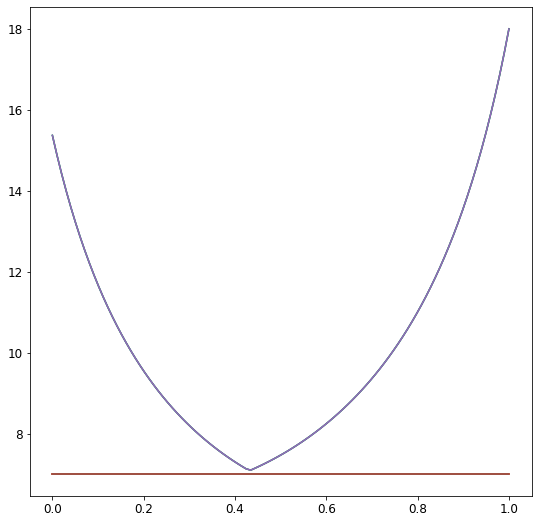

In [65]:
# Thickness optimization

P,Fx,T = loadcase(4)
R = 75

set_plot_props()
theta1 = 0
theta2 = 90

theta_B = 47
for  in range(3):
    t = 1
    t1 = np.linspace(0, 1, 100)
    t2 = t - t1
    fE_A = np.zeros_like(t1)
    fE_B = np.zeros_like(t1)

    for i in range(len(t1)):
        layupA =     [{'mat':m,  'ori':  theta1,  'thi':t1[i]/2},
                     {'mat':m,  'ori':  -theta1,  'thi':t1[i]/2},
                    {'mat':m,  'ori':  -theta2,  'thi':t2[i]/2},
                     {'mat':m,  'ori':  theta2,  'thi':t2[i]/2}]

        layupB =     [{'mat':m,  'ori':  theta_B,  'thi':t/2},
                     {'mat':m,  'ori':  -theta_B,  'thi':t/2}]


        res_iff = solve(layupA,R=75,P=P*1.2,Fx=Fx*1.2,T=T*1.2)
        res_iff_B = solve(layupB,R=75,P=P*1.2,Fx=Fx*1.2,T=T*1.2)

        #strain_iff = res_iff["global_strains"]
        fE[i] = res_iff["fE_iff"]
        fE_B[i] = res_iff_B["fE_iff"]

    i = fE.argmin() # Optimal fE
    print("Min fE=", fE[i], "t1=", t1[i], "t2=", t2[i])
    print("Min fE_B=", min(fE_B), "t=", t)

    plt.plot(t1, fE)
    plt.plot(t1, fE_B)



In [ ]:
# Thickness optimization

P,Fx,T = loadcase(5)
R = 75

set_plot_props()
theta1 = 0
theta2 = 80
t = 1
t1 = np.linspace(0, 1, 100)
t2 = t - t1
fE = np.zeros_like(t1)

for i in range(len(t1)):
    #print(t1 + t2)

    layup =     [{'mat':m,  'ori':  theta1,  'thi':t1[i]/2},
                 {'mat':m,  'ori':  theta2,  'thi':t2[i]},
                 {'mat':m,  'ori':  theta1,  'thi':t1[i]/2}]
    
    layup =     [{'mat':m,  'ori':  theta1,  'thi':t1[i]/2},
                 {'mat':m,  'ori':  -theta1,  'thi':t1[i]/2},
                 {'mat':m,  'ori':  theta2,  'thi':t2[i]/2},
                 {'mat':m,  'ori':  theta2,  'thi':t2[i]/2}]


    res_iff = solve(layup,R=75,P=P*1.2,Fx=Fx*1.2,T=T*1.2)
    #strain_iff = res_iff["global_strains"]
    fE[i] = res_iff["fE_iff"]

i = fE.argmin() # Optimal fE
print("Min fE=", fE[i], "t1=", t1[i], "t2=", t2[i])
plt.plot(t1, fE)



In [113]:
[[0]*10]*10

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]